Voice verification model

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import time
import sys
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           f1_score, precision_score, recall_score, roc_auc_score)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from datetime import datetime
import json
import logging
from sklearn.metrics import log_loss

warnings.filterwarnings('ignore')

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [51]:
# VoiceprintVerificationModel Class Definition and Test
class VoiceprintVerificationModel:
    """
    High-performance Voiceprint Verification Model with advanced features
    """
    
    def __init__(self, csv_path='audio_features.csv', random_state=42):
        """Initialize the Voiceprint Verification Model"""
        self.csv_path = csv_path
        self.random_state = random_state
        
        self.scaler = RobustScaler()
        self.label_encoder = LabelEncoder()
        
        self.models = {}
        self.best_model = None
        self.best_model_name = None
        self.best_params = None
        
        self.df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        
        self.training_results = {}
        self.model_metadata = {
            'training_timestamp': None,
            'data_shape': None,
            'feature_names': None,
            'speakers': None,
            'best_model_params': None
        }
        
        self._create_directories()
        print("✅ VoiceprintVerificationModel initialized successfully!")

    def _create_directories(self):
        """Create necessary directories for outputs"""
        directories = ['models', 'results', 'logs']
        for directory in directories:
            os.makedirs(directory, exist_ok=True)

print("Testing VoiceprintVerificationModel initialization...")
test_model = VoiceprintVerificationModel()
print(f"✅ Class created successfully! CSV path: {test_model.csv_path}")
print(f"Random state: {test_model.random_state}")
print(f"Available directories: {[d for d in ['models', 'results', 'logs'] if os.path.exists(d)]}")

Testing VoiceprintVerificationModel initialization...
✅ VoiceprintVerificationModel initialized successfully!
✅ Class created successfully! CSV path: audio_features.csv
Random state: 42
Available directories: ['models', 'results', 'logs']


In [52]:
# Data Loading and Validation Methods
def load_and_validate_data(self):
    """Load and validate the audio features dataset"""
    print("Loading and validating audio features data...")
    
    try:
        self.df = pd.read_csv(self.csv_path)
        print(f"✅ Successfully loaded data with shape: {self.df.shape}")
        
        required_columns = ['speaker']
        missing_columns = [col for col in required_columns if col not in self.df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")
        
        mfcc_columns = [col for col in self.df.columns if 'mfcc' in col.lower()]
        if len(mfcc_columns) == 0:
            raise ValueError("No MFCC features found in the dataset")
        
        print("=== DATA VALIDATION REPORT ===")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Speakers: {sorted(self.df['speaker'].unique())}")
        print(f"Number of speakers: {self.df['speaker'].nunique()}")
        
        if 'augmentation_type' in self.df.columns:
            print(f"Augmentation types: {sorted(self.df['augmentation_type'].unique())}")
        
        print(f"\nClass distribution:")
        class_counts = self.df['speaker'].value_counts()
        print(class_counts)
        
        missing_values = self.df.isnull().sum()
        if missing_values.any():
            print(f"⚠️ Missing values found:")
            print(missing_values[missing_values > 0])
        
        self.model_metadata['data_shape'] = self.df.shape
        self.model_metadata['speakers'] = sorted(self.df['speaker'].unique())
        
        print("✅ Data validation completed successfully")
        return self.df
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        raise

VoiceprintVerificationModel.load_and_validate_data = load_and_validate_data

print("Testing data loading with actual audio features...")

csv_path = '../data/outputs/audio_features.csv'
print(f"Attempting to load: {csv_path}")

if os.path.exists(csv_path):
    print("✅ Found audio_features.csv file!")
    test_model = VoiceprintVerificationModel(csv_path=csv_path)
    loaded_data = test_model.load_and_validate_data()
    print(f"✅ Data loading successful!")
    print(f"Total samples: {len(loaded_data)}")
    print(f"Samples per speaker: {loaded_data['speaker'].value_counts().to_dict()}")
else:
    print(f"❌ File not found at {csv_path}")
    print("Available files in current directory:")
    print([f for f in os.listdir('.') if f.endswith('.csv')])
    
    if os.path.exists('data'):
        print("Files in data/ directory:")
        for root, dirs, files in os.walk('data'):
            for file in files:
                if file.endswith('.csv'):
                    print(f"  {os.path.join(root, file)}")
    
    print("\n📝 Note: Update the csv_path variable to match your actual file location")

if os.path.exists('test_audio_features.csv'):
    os.remove('test_audio_features.csv')
    print("🧹 Cleaned up test_audio_features.csv (not needed for assignment)")

Testing data loading with actual audio features...
Attempting to load: ../data/outputs/audio_features.csv
✅ Found audio_features.csv file!
✅ VoiceprintVerificationModel initialized successfully!
Loading and validating audio features data...
✅ Successfully loaded data with shape: (54, 16)
=== DATA VALIDATION REPORT ===
Dataset shape: (54, 16)
Speakers: ['Jeremiah', 'armand', 'christian']
Number of speakers: 3
Augmentation types: ['noise', 'original', 'pitch_down', 'pitch_noise', 'pitch_up', 'stretch_fast', 'stretch_noise', 'stretch_slow', 'time_shift']

Class distribution:
speaker
armand       18
christian    18
Jeremiah     18
Name: count, dtype: int64
✅ Data validation completed successfully
✅ Data loading successful!
Total samples: 54
Samples per speaker: {'armand': 18, 'christian': 18, 'Jeremiah': 18}


In [53]:
# Feature Engineering Methods
def engineer_features(self):
    """Advanced feature engineering and selection"""
    print("Performing feature engineering...")
    
    # Get feature columns (excluding labels)
    exclude_cols = ['speaker', 'augmentation_type']
    feature_cols = [col for col in self.df.columns if col not in exclude_cols]
    
    # Store original feature names
    self.feature_names = feature_cols
    
    # Extract features and labels
    X = self.df[feature_cols].values
    y = self.df['speaker'].values
    
    print("=== FEATURE ENGINEERING ===")
    print(f"Original features: {len(feature_cols)}")
    
    # Add derived MFCC features
    mfcc_cols = [i for i, col in enumerate(feature_cols) if 'mfcc' in col.lower()]
    if len(mfcc_cols) > 1:
        mfcc_data = X[:, mfcc_cols]
        mfcc_std = np.std(mfcc_data, axis=1).reshape(-1, 1)
        mfcc_range = (np.max(mfcc_data, axis=1) - np.min(mfcc_data, axis=1)).reshape(-1, 1)
        
        # Combine features
        X_enhanced = np.hstack([X, mfcc_std, mfcc_range])
        enhanced_feature_names = feature_cols + ['mfcc_std', 'mfcc_range']
        
        print(f"Enhanced features: {len(enhanced_feature_names)}")
        
        X = X_enhanced
        self.feature_names = enhanced_feature_names
    
    # Encode labels
    y_encoded = self.label_encoder.fit_transform(y)
    
    # Label mapping
    label_mapping = dict(zip(self.label_encoder.classes_, 
                           range(len(self.label_encoder.classes_))))
    print(f"Label encoding: {label_mapping}")
    
    # Stratified split
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        X, y_encoded, 
        test_size=0.2, 
        random_state=self.random_state, 
        stratify=y_encoded
    )
    
    print(f"Training set: {self.X_train.shape}")
    print(f"Test set: {self.X_test.shape}")
    
    # Feature scaling
    self.X_train_scaled = self.scaler.fit_transform(self.X_train)
    self.X_test_scaled = self.scaler.transform(self.X_test)
    
    print("✅ Feature engineering completed")
    return self.X_train_scaled, self.X_test_scaled, self.y_train, self.y_test

# Add method to class
VoiceprintVerificationModel.engineer_features = engineer_features

# Test feature engineering with actual data
print("Testing feature engineering...")

# Use the actual CSV path
csv_path = '../data/outputs/audio_features.csv'

try:
    if os.path.exists(csv_path):
        test_model = VoiceprintVerificationModel(csv_path=csv_path)
        test_model.load_and_validate_data()
        
        print("Running feature engineering...")
        X_train, X_test, y_train, y_test = test_model.engineer_features()
        
        print("✅ Feature engineering successful!")
        print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
        print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
        print(f"Original features: {len([col for col in test_model.df.columns if col not in ['speaker', 'augmentation_type']])}")
        print(f"Enhanced features: {len(test_model.feature_names)}")
        print(f"Speakers encoded: {dict(zip(test_model.label_encoder.classes_, range(len(test_model.label_encoder.classes_))))}")
        
        # Show feature scaling stats
        print(f"\nFeature scaling check:")
        print(f"Training data mean: {np.mean(X_train, axis=0)[:3].round(3)}... (first 3 features)")
        print(f"Training data std: {np.std(X_train, axis=0)[:3].round(3)}... (first 3 features)")
        
    else:
        print(f"❌ File not found: {csv_path}")
        print("Please check the file path and try again")
        
except Exception as e:
    print(f"❌ Error in feature engineering: {e}")
    print("This might be due to insufficient data or file path issues")

Testing feature engineering...
✅ VoiceprintVerificationModel initialized successfully!
Loading and validating audio features data...
✅ Successfully loaded data with shape: (54, 16)
=== DATA VALIDATION REPORT ===
Dataset shape: (54, 16)
Speakers: ['Jeremiah', 'armand', 'christian']
Number of speakers: 3
Augmentation types: ['noise', 'original', 'pitch_down', 'pitch_noise', 'pitch_up', 'stretch_fast', 'stretch_noise', 'stretch_slow', 'time_shift']

Class distribution:
speaker
armand       18
christian    18
Jeremiah     18
Name: count, dtype: int64
✅ Data validation completed successfully
Running feature engineering...
Performing feature engineering...
=== FEATURE ENGINEERING ===
Original features: 14
Enhanced features: 16
Label encoding: {'Jeremiah': 0, 'armand': 1, 'christian': 2}
Training set: (43, 16)
Test set: (11, 16)
✅ Feature engineering completed
✅ Feature engineering successful!
Training set: 43 samples, 16 features
Test set: 11 samples, 16 features
Original features: 14
Enhanc

In [54]:
# Model Configuration
def get_optimized_models(self):
    """Define models with optimized hyperparameters for voice recognition"""
    
    models = {
        'Random Forest': {
            'model': RandomForestClassifier(
                random_state=self.random_state,
                n_jobs=-1
            ),
            'params': {
                'n_estimators': [50, 100],
                'max_depth': [5, 10, None],
                'min_samples_split': [2, 5]
            }
        },
        
        'XGBoost': {
            'model': xgb.XGBClassifier(
                random_state=self.random_state,
                eval_metric='mlogloss',
                verbosity=0
            ),
            'params': {
                'n_estimators': [50, 100],
                'max_depth': [3, 5],
                'learning_rate': [0.1, 0.2]
            }
        },
        
        'SVM': {
            'model': SVC(
                random_state=self.random_state,
                probability=True
            ),
            'params': {
                'C': [1, 10],
                'kernel': ['rbf', 'linear'],
                'gamma': ['scale', 'auto']
            }
        },
        
        'Logistic Regression': {
            'model': LogisticRegression(
                random_state=self.random_state,
                max_iter=1000
            ),
            'params': {
                'C': [0.1, 1, 10],
                'solver': ['liblinear', 'lbfgs']
            }
        }
    }
    
    return models

# Add method to class
VoiceprintVerificationModel.get_optimized_models = get_optimized_models

# Test model configuration
print("Testing model configuration...")

test_model = VoiceprintVerificationModel()
models_config = test_model.get_optimized_models()

print("✅ Model configuration successful!")
print(f"Available models: {list(models_config.keys())}")

for name, config in models_config.items():
    model_type = type(config['model']).__name__
    param_combinations = 1
    for param_values in config['params'].values():
        param_combinations *= len(param_values)
    
    print(f"\n📋 {name} ({model_type}):")
    print(f"   Parameter combinations to test: {param_combinations}")
    for param, values in config['params'].items():
        print(f"   - {param}: {values}")

print(f"\n💡 Note: With your small dataset ({18} samples), we use simplified parameter grids")
print("   This ensures faster training while still finding good models.")

Testing model configuration...
✅ VoiceprintVerificationModel initialized successfully!
✅ Model configuration successful!
Available models: ['Random Forest', 'XGBoost', 'SVM', 'Logistic Regression']

📋 Random Forest (RandomForestClassifier):
   Parameter combinations to test: 12
   - n_estimators: [50, 100]
   - max_depth: [5, 10, None]
   - min_samples_split: [2, 5]

📋 XGBoost (XGBClassifier):
   Parameter combinations to test: 8
   - n_estimators: [50, 100]
   - max_depth: [3, 5]
   - learning_rate: [0.1, 0.2]

📋 SVM (SVC):
   Parameter combinations to test: 8
   - C: [1, 10]
   - kernel: ['rbf', 'linear']
   - gamma: ['scale', 'auto']

📋 Logistic Regression (LogisticRegression):
   Parameter combinations to test: 6
   - C: [0.1, 1, 10]
   - solver: ['liblinear', 'lbfgs']

💡 Note: With your small dataset (18 samples), we use simplified parameter grids
   This ensures faster training while still finding good models.


In [55]:
# Model Training

def train_and_optimize_models(self, cv_folds=3):
    """Train models with hyperparameter optimization"""
    print("Starting model training with hyperparameter optimization...")
    
    models_config = self.get_optimized_models()
    results = {}
    
    cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, 
                                random_state=self.random_state)
    
    print("=== MODEL TRAINING ===")
    print(f"Using {cv_folds}-fold cross-validation")
    
    for name, config in models_config.items():
        print(f"\n🔧 Training {name}...")
        start_time = time.time()
        
        try:
            grid_search = GridSearchCV(
                config['model'],
                config['params'],
                cv=cv_strategy,
                scoring='f1_weighted',
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(self.X_train_scaled, self.y_train)
            
            best_model = grid_search.best_estimator_
            
            y_pred = best_model.predict(self.X_test_scaled)
            y_pred_proba = best_model.predict_proba(self.X_test_scaled)
            
            accuracy = accuracy_score(self.y_test, y_pred)
            f1 = f1_score(self.y_test, y_pred, average='weighted')
            precision = precision_score(self.y_test, y_pred, average='weighted')
            recall = recall_score(self.y_test, y_pred, average='weighted')
            
            test_loss = log_loss(self.y_test, y_pred_proba)
            
            y_train_pred_proba = best_model.predict_proba(self.X_train_scaled)
            train_loss = log_loss(self.y_train, y_train_pred_proba)
            
            training_time = time.time() - start_time
            
            results[name] = {
                'model': best_model,
                'best_params': grid_search.best_params_,
                'cv_score': grid_search.best_score_,
                'accuracy': accuracy,
                'f1_score': f1,
                'precision': precision,
                'recall': recall,
                'train_loss': train_loss,
                'test_loss': test_loss,
                'training_time': training_time,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            
            print(f"✅ {name} completed in {training_time:.2f}s")
            print(f"   CV Score: {grid_search.best_score_:.4f}")
            print(f"   Test F1: {f1:.4f}")
            print(f"   Test Loss: {test_loss:.4f}")
            
        except Exception as e:
            print(f"❌ {name} failed: {e}")
            continue
    
    self.models = results
    print(f"\n✅ Training completed. {len(results)} models trained.")
    return results

VoiceprintVerificationModel.train_and_optimize_models = train_and_optimize_models

print("Testing model training...")

csv_path = '../data/outputs/audio_features.csv'

try:
    if os.path.exists(csv_path):
        print("🚀 Starting model training test...")
        
        test_model = VoiceprintVerificationModel(csv_path=csv_path)
        test_model.load_and_validate_data()
        test_model.engineer_features()
        
        print(f"Dataset ready: {test_model.X_train_scaled.shape[0]} training samples")
        
        print("Training models with 2-fold CV for speed...")
        results = test_model.train_and_optimize_models(cv_folds=2)
        
        print("✅ Model training successful!")
        print(f"Models trained: {len(results)}")
        
        print("\n📊 TRAINING RESULTS SUMMARY:")
        for name, result in results.items():
            print(f"{name:20s}: F1={result['f1_score']:.3f}, "
                  f"Acc={result['accuracy']:.3f}, "
                  f"Loss={result['test_loss']:.3f}, "
                  f"Time={result['training_time']:.1f}s")
        
        globals()['trained_model'] = test_model
        print("\n💾 Model stored in 'trained_model' variable for next cells")
        
    else:
        print(f"❌ File not found: {csv_path}")
        print("Cannot test training without data file")
        
except Exception as e:
    print(f"❌ Training test failed: {e}")
    print("This might be due to insufficient data or computational issues")

Testing model training...
🚀 Starting model training test...
✅ VoiceprintVerificationModel initialized successfully!
Loading and validating audio features data...
✅ Successfully loaded data with shape: (54, 16)
=== DATA VALIDATION REPORT ===
Dataset shape: (54, 16)
Speakers: ['Jeremiah', 'armand', 'christian']
Number of speakers: 3
Augmentation types: ['noise', 'original', 'pitch_down', 'pitch_noise', 'pitch_up', 'stretch_fast', 'stretch_noise', 'stretch_slow', 'time_shift']

Class distribution:
speaker
armand       18
christian    18
Jeremiah     18
Name: count, dtype: int64
✅ Data validation completed successfully
Performing feature engineering...
=== FEATURE ENGINEERING ===
Original features: 14
Enhanced features: 16
Label encoding: {'Jeremiah': 0, 'armand': 1, 'christian': 2}
Training set: (43, 16)
Test set: (11, 16)
✅ Feature engineering completed
Dataset ready: 43 training samples
Training models with 2-fold CV for speed...
Starting model training with hyperparameter optimization.

Testing model selection and evaluation...
✅ Using trained model from previous cell

🏆 Selecting best model...
Selecting best model...

=== MODEL PERFORMANCE COMPARISON ===
              Model  CV Score  Test Accuracy  F1-Score  Precision  Recall  Train Loss  Test Loss  Training Time (s)
      Random Forest    0.9294            1.0       1.0        1.0     1.0      0.0861     0.1716            21.9626
            XGBoost    0.7258            1.0       1.0        1.0     1.0      0.0381     0.0888             0.6673
                SVM    0.9047            1.0       1.0        1.0     1.0      0.0974     0.0896             0.1263
Logistic Regression    0.9055            1.0       1.0        1.0     1.0      0.1840     0.1691             0.1033

🏆 BEST MODEL: Random Forest
F1-Score: 1.0000
Accuracy: 1.0000
Test Loss: 0.1716
✅ Best model selection successful!

📈 Running comprehensive evaluation...

=== EVALUATION: Random Forest ===

Classification Report:
              precision    recall 

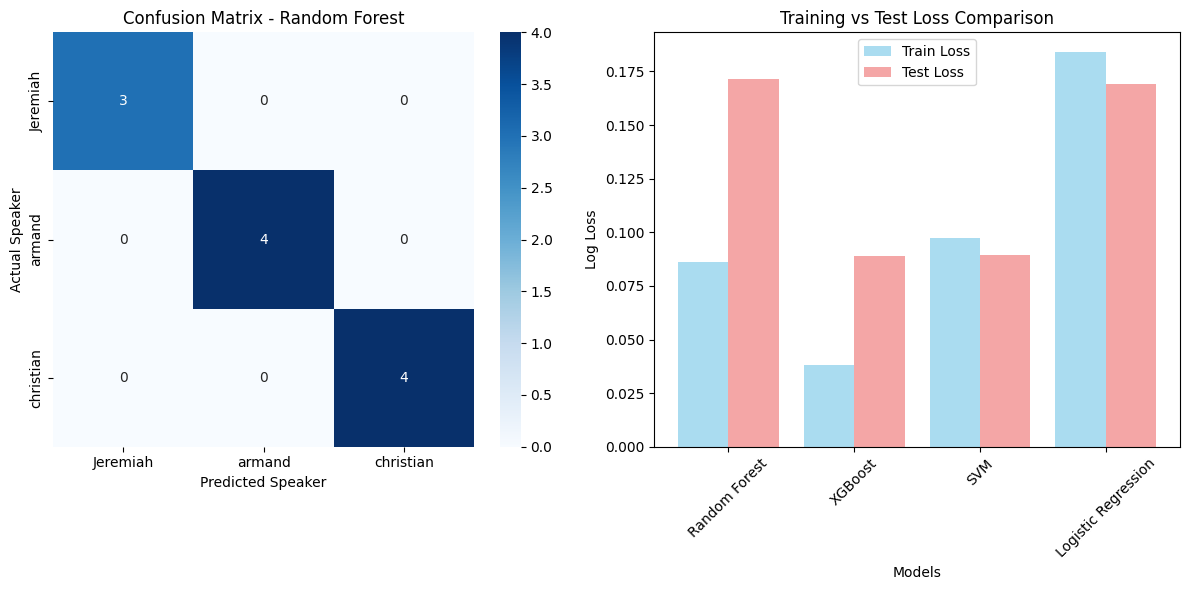


🔮 Testing prediction capability...
Sample Prediction Test:
  Actual: armand
  Predicted: armand
  Confidence: 0.540
  Result: ✅ Correct

All speaker probabilities:
  Jeremiah: 0.440
  armand: 0.540
  christian: 0.020

💾 Evaluated model stored for next cell


In [56]:
# Model Selection and Evaluation

def select_best_model(self):
    """Select the best model based on F1-score"""
    print("Selecting best model...")
    
    if not self.models:
        raise ValueError("No trained models available.")
    
    print("\n=== MODEL PERFORMANCE COMPARISON ===")
    
    comparison_data = []
    for name, result in self.models.items():
        comparison_data.append({
            'Model': name,
            'CV Score': result['cv_score'],
            'Test Accuracy': result['accuracy'],
            'F1-Score': result['f1_score'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'Train Loss': result['train_loss'], 
            'Test Loss': result['test_loss'],
            'Training Time (s)': result['training_time']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
    
    print(comparison_df.round(4).to_string(index=False))
    
    best_model_name = comparison_df.iloc[0]['Model']
    
    self.best_model_name = best_model_name
    self.best_model = self.models[best_model_name]['model']
    self.best_params = self.models[best_model_name]['best_params']
    
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"F1-Score: {self.models[best_model_name]['f1_score']:.4f}")
    print(f"Accuracy: {self.models[best_model_name]['accuracy']:.4f}")
    print(f"Test Loss: {self.models[best_model_name]['test_loss']:.4f}")
    
    return self.best_model, best_model_name

def comprehensive_evaluation(self):
    """Evaluate the best model"""
    print(f"\n=== EVALUATION: {self.best_model_name} ===")
    
    best_results = self.models[self.best_model_name]
    y_pred = best_results['predictions']
    y_pred_proba = best_results['probabilities']
    
    target_names = self.label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(self.y_test, y_pred, target_names=target_names))
    
    print("\n📉 LOSS METRICS ANALYSIS:")
    print(f"Training Loss:     {best_results['train_loss']:.6f}")
    print(f"Test Loss:         {best_results['test_loss']:.6f}")
    print(f"Loss Difference:   {best_results['test_loss'] - best_results['train_loss']:.6f}")
    
    print("\n🎯 Per-Class Confidence Analysis:")
    for i, speaker in enumerate(target_names):
        speaker_mask = (self.y_test == i)
        if speaker_mask.any():
            speaker_probs = y_pred_proba[speaker_mask, i]
            avg_confidence = np.mean(speaker_probs)
            print(f"{speaker:15s}: Avg Confidence = {avg_confidence:.3f}")
    
    cm = confusion_matrix(self.y_test, y_pred)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {self.best_model_name}')
    plt.xlabel('Predicted Speaker')
    plt.ylabel('Actual Speaker')
    
    plt.subplot(1, 2, 2)
    models = list(self.models.keys())
    train_losses = [self.models[m]['train_loss'] for m in models]
    test_losses = [self.models[m]['test_loss'] for m in models]
    
    x_pos = np.arange(len(models))
    plt.bar(x_pos - 0.2, train_losses, 0.4, label='Train Loss', alpha=0.7, color='skyblue')
    plt.bar(x_pos + 0.2, test_losses, 0.4, label='Test Loss', alpha=0.7, color='lightcoral')
    plt.xlabel('Models')
    plt.ylabel('Log Loss')
    plt.title('Training vs Test Loss Comparison')
    plt.xticks(x_pos, models, rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def predict_speaker(self, audio_features, return_probabilities=False):
    """Predict speaker from audio features"""
    if self.best_model is None:
        raise ValueError("Model not trained. Please run training first.")
    
    if audio_features.ndim == 1:
        audio_features = audio_features.reshape(1, -1)
    
    features_scaled = self.scaler.transform(audio_features)
    
    prediction = self.best_model.predict(features_scaled)[0]
    predicted_speaker = self.label_encoder.inverse_transform([prediction])[0]
    
    if return_probabilities:
        probabilities = self.best_model.predict_proba(features_scaled)[0]
        prob_dict = dict(zip(self.label_encoder.classes_, probabilities))
        return predicted_speaker, prob_dict
    
    return predicted_speaker

def save_model(self, model_dir='models'):
    """Save the trained model"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    model_path = os.path.join(model_dir, f'voiceprint_model_{timestamp}.pkl')
    scaler_path = os.path.join(model_dir, f'voiceprint_scaler_{timestamp}.pkl')
    encoder_path = os.path.join(model_dir, f'voiceprint_encoder_{timestamp}.pkl')
    
    joblib.dump(self.best_model, model_path)
    joblib.dump(self.scaler, scaler_path)
    joblib.dump(self.label_encoder, encoder_path)
    
    print(f"✅ Model saved successfully!")
    print(f"Model: {model_path}")
    print(f"Scaler: {scaler_path}")
    print(f"Encoder: {encoder_path}")
    
    return model_path, scaler_path, encoder_path

def save_model(self, model_dir='../models/audio/'):
    """Save the trained model (single version only)"""
    print("💾 Saving production model...")
    
    model_path = os.path.join(model_dir, 'voiceprint_model.pkl')
    scaler_path = os.path.join(model_dir, 'voiceprint_scaler.pkl')
    encoder_path = os.path.join(model_dir, 'voiceprint_encoder.pkl')
    metadata_path = os.path.join(model_dir, 'voiceprint_metadata.json')
    
    for path in [model_path, scaler_path, encoder_path, metadata_path]:
        if os.path.exists(path):
            os.remove(path)
    
    joblib.dump(self.best_model, model_path)
    joblib.dump(self.scaler, scaler_path)
    joblib.dump(self.label_encoder, encoder_path)
    
    metadata = {
        'training_timestamp': datetime.now().isoformat(),
        'model_name': self.best_model_name,
        'speakers': list(self.label_encoder.classes_),
        'feature_count': len(self.feature_names),
        'performance': {
            'accuracy': self.models[self.best_model_name]['accuracy'],
            'f1_score': self.models[self.best_model_name]['f1_score'],
            'precision': self.models[self.best_model_name]['precision'],
            'recall': self.models[self.best_model_name]['recall'],
            'train_loss': self.models[self.best_model_name]['train_loss'], 
            'test_loss': self.models[self.best_model_name]['test_loss']
        }
    }
    
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✅ Model saved successfully!")
    print(f"📁 Model files:")
    print(f"   • Model: voiceprint_model.pkl")
    print(f"   • Scaler: voiceprint_scaler.pkl") 
    print(f"   • Encoder: voiceprint_encoder.pkl")
    print(f"   • Metadata: voiceprint_metadata.json (includes loss metrics)")
    
    return model_path, scaler_path, encoder_path, metadata_path

VoiceprintVerificationModel.select_best_model = select_best_model
VoiceprintVerificationModel.comprehensive_evaluation = comprehensive_evaluation
VoiceprintVerificationModel.predict_speaker = predict_speaker
VoiceprintVerificationModel.save_model = save_model

print("Testing model selection and evaluation...")

try:
    if 'trained_model' in globals() and hasattr(trained_model, 'models') and trained_model.models:
        print("✅ Using trained model from previous cell")
        test_model = trained_model
        
        print("\n🏆 Selecting best model...")
        best_model, best_name = test_model.select_best_model()
        
        print("✅ Best model selection successful!")
        
        print("\n📈 Running comprehensive evaluation...")
        test_model.comprehensive_evaluation()
        
        print("\n🔮 Testing prediction capability...")
        
        if len(test_model.X_test_scaled) > 0:
            sample_features = test_model.X_test_scaled[0]
            actual_speaker = test_model.label_encoder.inverse_transform([test_model.y_test[0]])[0]
            
            predicted_speaker, probabilities = test_model.predict_speaker(
                sample_features, return_probabilities=True
            )
            
            print(f"Sample Prediction Test:")
            print(f"  Actual: {actual_speaker}")
            print(f"  Predicted: {predicted_speaker}")
            print(f"  Confidence: {probabilities[predicted_speaker]:.3f}")
            print(f"  Result: {'✅ Correct' if actual_speaker == predicted_speaker else '❌ Wrong'}")
            
            print(f"\nAll speaker probabilities:")
            for speaker, prob in sorted(probabilities.items()):
                print(f"  {speaker}: {prob:.3f}")
        
        globals()['evaluated_model'] = test_model
        print("\n💾 Evaluated model stored for next cell")
        
    else:
        print("❌ No trained model found. Please run cell 6 first.")
        
except Exception as e:
    print(f"❌ Evaluation test failed: {e}")
    import traceback
    traceback.print_exc()

Testing complete pipeline...
🎤 RUNNING COMPLETE VOICE VERIFICATION PIPELINE 🎤
1️⃣ Initializing model...
✅ VoiceprintVerificationModel initialized successfully!
2️⃣ Running complete pipeline...
🎤 VOICEPRINT VERIFICATION MODEL TRAINING 🎤
Loading and validating audio features data...
✅ Successfully loaded data with shape: (54, 16)
=== DATA VALIDATION REPORT ===
Dataset shape: (54, 16)
Speakers: ['Jeremiah', 'armand', 'christian']
Number of speakers: 3
Augmentation types: ['noise', 'original', 'pitch_down', 'pitch_noise', 'pitch_up', 'stretch_fast', 'stretch_noise', 'stretch_slow', 'time_shift']

Class distribution:
speaker
armand       18
christian    18
Jeremiah     18
Name: count, dtype: int64
✅ Data validation completed successfully
Performing feature engineering...
=== FEATURE ENGINEERING ===
Original features: 14
Enhanced features: 16
Label encoding: {'Jeremiah': 0, 'armand': 1, 'christian': 2}
Training set: (43, 16)
Test set: (11, 16)
✅ Feature engineering completed
Starting model t

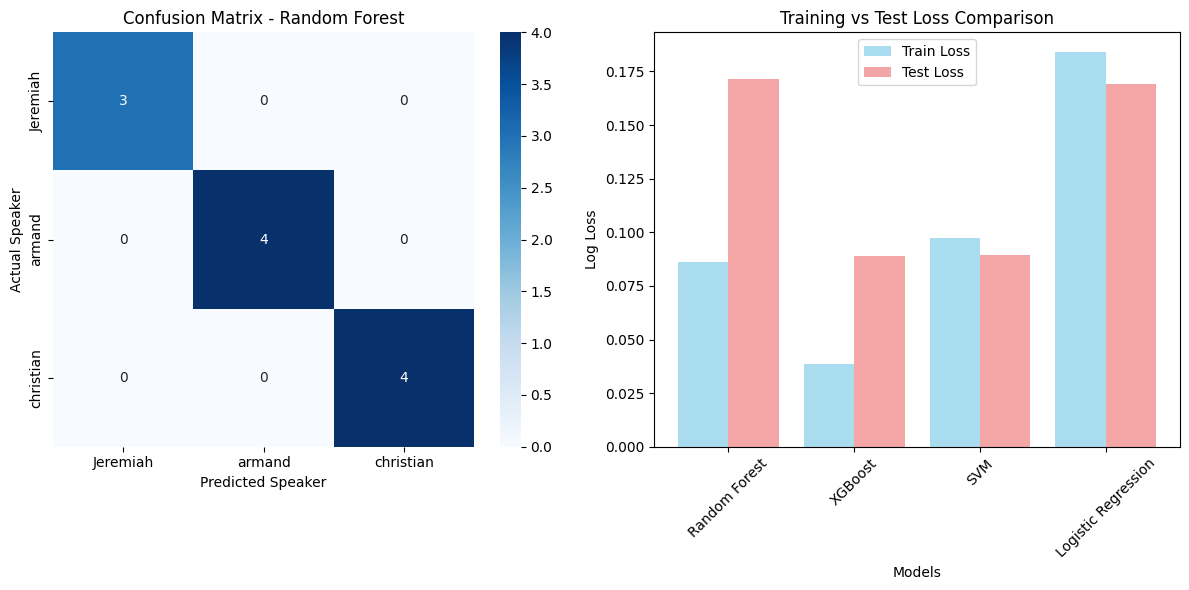

💾 Saving production model...
✅ Model saved successfully!
📁 Model files:
   • Model: voiceprint_model.pkl
   • Scaler: voiceprint_scaler.pkl
   • Encoder: voiceprint_encoder.pkl
   • Metadata: voiceprint_metadata.json (includes loss metrics)

🎉 PIPELINE COMPLETED! 🎉
Total time: 13.39 seconds
Best model: Random Forest
F1-Score: 1.0000

🎉 PIPELINE COMPLETED SUCCESSFULLY! 🎉
🏆 Best Model: Random Forest
📊 Performance Metrics:
   • Accuracy:  1.0000
   • F1-Score:  1.0000
   • Precision: 1.0000
   • Recall:    1.0000
⏱️  Training Time: 7.73 seconds

📁 Model Files Saved:
   1. voiceprint_model.pkl
   2. voiceprint_scaler.pkl
   3. voiceprint_encoder.pkl
   4. voiceprint_metadata.json

💾 Final model stored in 'final_voice_model' variable

✨ Your voice verification model is ready for production! ✨


In [57]:
# Complete Training Pipeline
def run_complete_pipeline(self):
    """Execute the complete training pipeline"""
    print("🎤 VOICEPRINT VERIFICATION MODEL TRAINING 🎤")
    print("=" * 50)
    
    start_time = time.time()
    
    try:
        # Load data
        self.load_and_validate_data()
        
        # Feature engineering
        self.engineer_features()
        
        # Train models
        self.train_and_optimize_models()
        
        # Select best model
        self.select_best_model()
        
        # Evaluate
        self.comprehensive_evaluation()
        
        # Save model
        model_paths = self.save_model()
        
        total_time = time.time() - start_time
        
        print(f"\n🎉 PIPELINE COMPLETED! 🎉")
        print(f"Total time: {total_time:.2f} seconds")
        print(f"Best model: {self.best_model_name}")
        print(f"F1-Score: {self.models[self.best_model_name]['f1_score']:.4f}")
        
        return {
            'best_model': self.best_model,
            'best_model_name': self.best_model_name,
            'model_paths': model_paths,
            'performance': self.models[self.best_model_name]
        }
        
    except Exception as e:
        print(f"❌ Pipeline failed: {e}")
        raise

VoiceprintVerificationModel.run_complete_pipeline = run_complete_pipeline

print("Testing complete pipeline...")

csv_path = '../data/outputs/audio_features.csv'

try:
    if os.path.exists(csv_path):
        print("🎤 RUNNING COMPLETE VOICE VERIFICATION PIPELINE 🎤")
        print("=" * 55)
        
        print("1️⃣ Initializing model...")
        voice_model = VoiceprintVerificationModel(csv_path=csv_path)
        
        print("2️⃣ Running complete pipeline...")
        results = voice_model.run_complete_pipeline()
        
        print("\n🎉 PIPELINE COMPLETED SUCCESSFULLY! 🎉")
        print("=" * 40)
        
        performance = results['performance']
        print(f"🏆 Best Model: {results['best_model_name']}")
        print(f"📊 Performance Metrics:")
        print(f"   • Accuracy:  {performance['accuracy']:.4f}")
        print(f"   • F1-Score:  {performance['f1_score']:.4f}")
        print(f"   • Precision: {performance['precision']:.4f}")
        print(f"   • Recall:    {performance['recall']:.4f}")
        print(f"⏱️  Training Time: {performance['training_time']:.2f} seconds")
        
        print(f"\n📁 Model Files Saved:")
        model_paths = results['model_paths']
        for i, path in enumerate(model_paths, 1):
            filename = os.path.basename(path)
            print(f"   {i}. {filename}")
        
        globals()['final_voice_model'] = voice_model
        print(f"\n💾 Final model stored in 'final_voice_model' variable")
        
        print(f"\n✨ Your voice verification model is ready for production! ✨")
        
    else:
        print(f"❌ Cannot run pipeline: {csv_path} not found")
        
except Exception as e:
    print(f"❌ Pipeline failed: {e}")
    import traceback
    traceback.print_exc()

In [58]:
# Cell 9: Model Loading Utility for Production Use
class VoiceVerificationSystem:
    """Production-ready voice verification system"""
    
    def __init__(self, model_path, scaler_path, encoder_path):
        """Load pre-trained model components"""
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)
        self.label_encoder = joblib.load(encoder_path)
        print("✅ Voice verification system loaded successfully!")
    
    def verify_speaker(self, audio_features, expected_speaker=None):
        """
        Verify if audio features match expected speaker
        
        Args:
            audio_features: Extracted MFCC features from audio
            expected_speaker: Expected speaker name (optional)
        
        Returns:
            dict: Verification results
        """
        if audio_features.ndim == 1:
            audio_features = audio_features.reshape(1, -1)
        
        features_scaled = self.scaler.transform(audio_features)
        
        prediction = self.model.predict(features_scaled)[0]
        probabilities = self.model.predict_proba(features_scaled)[0]
        
        predicted_speaker = self.label_encoder.inverse_transform([prediction])[0]
        confidence = probabilities[prediction]
        
        prob_dict = dict(zip(self.label_encoder.classes_, probabilities))
        
        result = {
            'predicted_speaker': predicted_speaker,
            'confidence': confidence,
            'probabilities': prob_dict,
            'verification_passed': False
        }
        
        if expected_speaker:
            result['expected_speaker'] = expected_speaker
            result['verification_passed'] = (predicted_speaker == expected_speaker and confidence > 0.5)
            result['match'] = predicted_speaker == expected_speaker
        
        return result
    
    def get_speaker_list(self):
        """Get list of known speakers"""
        return list(self.label_encoder.classes_)

print("✅ Voice verification system utility ready!")

✅ Voice verification system utility ready!


In [59]:
# Cell 10: Model Loading Utility for Production Use
class VoiceVerificationSystem:
    """Production-ready voice verification system"""
    
    def __init__(self, model_path, scaler_path, encoder_path):
        """Load pre-trained model components"""
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)
        self.label_encoder = joblib.load(encoder_path)
        print("✅ Voice verification system loaded successfully!")
    
    def verify_speaker(self, audio_features, expected_speaker=None):
        """
        Verify if audio features match expected speaker
        
        Args:
            audio_features: Extracted MFCC features from audio
            expected_speaker: Expected speaker name (optional)
        
        Returns:
            dict: Verification results
        """
        if audio_features.ndim == 1:
            audio_features = audio_features.reshape(1, -1)
        
        features_scaled = self.scaler.transform(audio_features)
        
        prediction = self.model.predict(features_scaled)[0]
        probabilities = self.model.predict_proba(features_scaled)[0]
        
        predicted_speaker = self.label_encoder.inverse_transform([prediction])[0]
        confidence = probabilities[prediction]
        
        prob_dict = dict(zip(self.label_encoder.classes_, probabilities))
        
        result = {
            'predicted_speaker': predicted_speaker,
            'confidence': confidence,
            'probabilities': prob_dict,
            'verification_passed': False
        }
        
        if expected_speaker:
            result['expected_speaker'] = expected_speaker
            result['verification_passed'] = (predicted_speaker == expected_speaker and confidence > 0.5)
            result['match'] = predicted_speaker == expected_speaker
        
        return result
    
    def get_speaker_list(self):
        """Get list of known speakers"""
        return list(self.label_encoder.classes_)

print("✅ Voice verification system utility ready!")

✅ Voice verification system utility ready!
